In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tools.rsa import correlate_rsms
from scipy.stats import pearsonr
from collections import defaultdict
from joblib import Parallel, delayed
from statsmodels.stats.multitest import multipletests


import numpy as np
import pandas as pd
from tools.rsa import compute_similarity
from tools.rsa import correlate_rsms
from tools.stats import average_pearson_r
from srf.helpers import load_spose_embedding
from scipy.optimize import linear_sum_assignment
from joblib import Parallel, delayed
from srf.simulation import add_noise_with_snr
from srf.models.trifactor import TriFactor
from srf.models.mixed import SymmetricMixed
from pathlib import Path



/LOCAL/fmahner/srf/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hypothesis testing simulation based on SPoSE

In [2]:
def aligned_latent_correlation_by_dimension(x, w):
    """we find the best alignment between the latent dimensions of x and w"""
    # Ensure inputs are numpy arrays
    x, w = np.asarray(x), np.asarray(w)
    rank = x.shape[1]

    # Compute the correlation matrix between each pair of columns
    corr_matrix = np.zeros((rank, rank))
    for i in range(rank):
        for j in range(rank):
            corr_matrix[i, j] = np.corrcoef(x[:, i], w[:, j])[0, 1]

    # Use the Hungarian algorithm to maximize the sum of absolute correlations.
    # Since linear_sum_assignment minimizes cost, we use negative absolute correlations.
    cost_matrix = -np.abs(corr_matrix)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Compute the mean correlation for the best aligned columns
    aligned_corrs = [corr_matrix[i, j] for i, j in zip(row_ind, col_ind)]
    mean_corr = average_pearson_r(aligned_corrs)
    return mean_corr

In [3]:
class Config:
    snr_list = np.linspace(0, 1.0, 5).round(2)
    n_repeats = 1
    n_permutations = 1_000
    max_objects = 100
    MAX_JOBS = 140
    dims = [3, 5, 8, 12, 14]  # subsample of the spose dimensions


cfg = Config()

data = load_spose_embedding(max_objects=cfg.max_objects, max_dims=66)
data = data[:, cfg.dims]
cfg.rank = len(cfg.dims)
hypotheses = []
for i in range(cfg.rank):
    x_i = data[:, [i]]
    s_i = x_i @ x_i.T
    hypotheses.append(s_i)

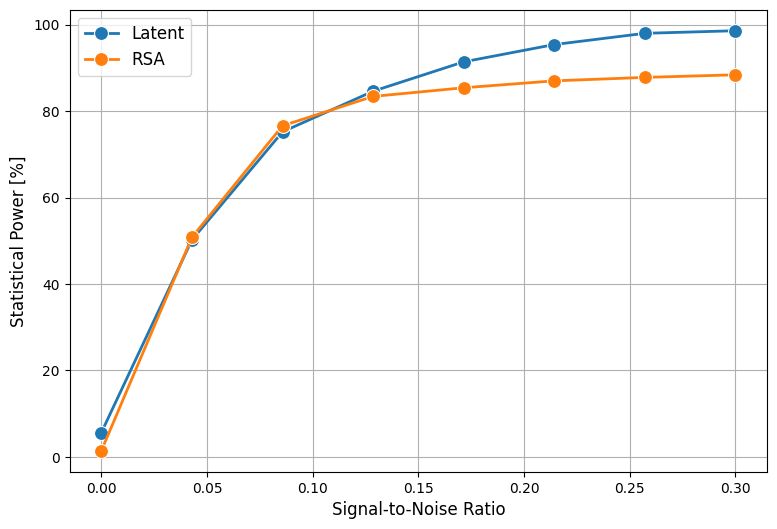

In [4]:
# power is the number of times we reject the null hypothesis divided by the total number of permutations
# Average over per
results_df = pd.read_csv("/LOCAL/fmahner/srf/results/benchmarks/hypothesis_tests.csv")

# Drop NMF
results_df = results_df[results_df["Method"] != "NMF"]
power_df = results_df.groupby(["SNR", "Method"])["Significant"].mean().reset_index()
power_df["Significant"] *= 100  # Convert to percentage
# Create plot using seaborn
plt.figure(figsize=(9, 6))
sns.lineplot(
    data=power_df,
    x="SNR",
    y="Significant",
    hue="Method",
    marker="o",
    linewidth=2,
    markersize=10,
)

plt.xlabel("Signal-to-Noise Ratio", fontsize=12)
plt.ylabel("Statistical Power [%]", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)